In [24]:
from IPython.display import display

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [26]:
df = pd.read_csv("compas-scores-two-years.csv", index_col=0)

In [27]:
top_10_charges = df['c_charge_desc'].value_counts().head(10).index
df = df[df['c_charge_desc'].isin(top_10_charges)]

df['end'] = df['end'].astype('datetime64[ns]')
df['start'] = df['start'].astype('datetime64[ns]')
df['days_in_jail'] = (df['end'] - df['start']).dt.days
df['days_in_jail'] = df['days_in_jail'].astype('int64')
df['days_in_jail'] = df['days_in_jail'].replace(-1, np.nan)  # replace -1 with NaN
df['is_still_in_jail'] = df['end'].isna()  # 1 if still in jail, 0 otherwise

categorical_features = ['sex', #Male/Female
                        'race', #African-American, Caucasian, Hispanic, Other, Asian, Native American
                        'c_charge_degree', #F (Felony), M (Misdemeanor)
                        #'c_charge_desc',
                        'type_of_assessment']
quantitative_features = ['age', 
                         'juv_fel_count', 
                         'juv_misd_count', 
                         'juv_other_count', 
                         'priors_count', 
                         'days_b_screening_arrest', 
                         'days_in_jail']
ordinal_features = ['age_cat',
                    'score_text',
                    'decile_score']
y = df['two_year_recid']

X = df[categorical_features + quantitative_features].values
X_quantitative = df[quantitative_features].values
X_categorical = df[categorical_features].values
X_ordinal = df[ordinal_features].values

## Encoding variables

### One-Hot Encoding (Categorical features)

In [28]:
from sklearn.preprocessing import OneHotEncoder

In [29]:
one_hot_encoder = OneHotEncoder()
one_hot_encoder.fit(X_categorical)
one_hot_encoded_X = one_hot_encoder.transform(X_categorical)

df_categorical = df[categorical_features]

categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df, columns=categorical_cols)

print("Number of new columns generated after one-hot encoding:", df_encoded.shape[1] - df.shape[1])

X_categorical_encoded = df_encoded
X_categorical_encoded

Number of new columns generated after one-hot encoding: 33650


,age,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_days_from_compas,is_recid,r_days_from_arrest,...,out_custody_2016-03-27,out_custody_2016-03-28,out_custody_2016-03-29,out_custody_2016-03-30,out_custody_2016-04-04,out_custody_2016-04-05,out_custody_2016-04-06,out_custody_2016-04-09,out_custody_2016-04-19,out_custody_2020-01-01
id,,,,,,,,,,,,,,,,,,,,,
4,24,0,4,0,1,4,-1.0,1.0,1,0.0,...,False,False,False,False,False,False,False,False,False,False
6,43,0,1,0,0,2,NaN,76.0,0,NaN,...,False,False,False,False,False,False,False,False,False,False
7,44,0,1,0,0,0,0.0,0.0,0,NaN,...,False,False,False,False,False,False,False,False,False,False
9,43,0,4,0,0,3,-1.0,1.0,0,NaN,...,False,False,False,False,False,False,False,False,False,False
10,39,0,1,0,0,0,-1.0,1.0,0,NaN,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10989,30,0,4,0,0,2,-1.0,1.0,0,NaN,...,False,False,False,False,False,False,False,False,False,False
10990,23,0,10,2,1,5,52.0,142.0,1,0.0,...,False,False,False,False,False,False,False,False,False,False
10992,21,0,6,0,0,0,-1.0,1.0,1,NaN,...,False,False,False,False,False,False,False,False,False,False


### Ordinal Encoding

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

In [31]:
ordinal_encoder = OrdinalEncoder()

X_ordinal_encoded = np.zeros_like(X_ordinal)

for i in range(X_ordinal.shape[1]):
    colonne_reshape = X_ordinal[:, i].reshape(-1, 1)
    
    colonne_encoded = ordinal_encoder.fit_transform(colonne_reshape)
    
    X_ordinal_encoded[:, i] = colonne_encoded.flatten()
    
for i, col in enumerate(ordinal_features):
    print(f"===== Encoded classes for {col}: {ordinal_encoder.categories_}")
    

===== Encoded classes for age_cat: [array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=object)]
===== Encoded classes for score_text: [array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=object)]
===== Encoded classes for decile_score: [array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], dtype=object)]


### Standard Scaling (quantitative)

In [32]:
from sklearn.preprocessing import StandardScaler

In [33]:
scaler = StandardScaler()

X_quantitative_scaled = scaler.fit_transform(X_quantitative)
X_quantitative_scaled

array([[-0.93609573, -0.14837614, -0.18309303, ...,  0.0713139 ,
        -0.06443879,  0.        ],
       [ 0.67798804, -0.14837614, -0.18309303, ..., -0.32585433,
                nan,  0.        ],
       [ 0.76293981, -0.14837614, -0.18309303, ..., -0.72302255,
        -0.05208786,  0.        ],
       ...,
       [-1.19095106, -0.14837614, -0.18309303, ..., -0.72302255,
        -0.06443879,  0.        ],
       [-0.42638507, -0.14837614, -0.18309303, ..., -0.72302255,
        -0.06443879,  0.        ],
       [-1.27590284, -0.14837614, -0.18309303, ..., -0.72302255,
        -0.06443879,  0.        ]], shape=(3918, 7))

# New Dataset

In [34]:
df_quantitative_scaled = pd.DataFrame(X_quantitative_scaled, columns=quantitative_features)
df_ordinal_encoded = pd.DataFrame(X_ordinal_encoded, columns=ordinal_features)
df_categorical_encoded = pd.DataFrame(X_categorical_encoded, columns=one_hot_encoder.get_feature_names_out(categorical_features))

df_final = pd.concat([df_quantitative_scaled, df_ordinal_encoded, df_categorical_encoded, y], axis=1)
df_final.head()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,days_in_jail,age_cat,score_text,decile_score,...,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,two_year_recid
0,-0.936096,-0.148376,-0.183093,1.930558,0.071314,-0.064439,0.0,2.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.677988,-0.148376,-0.183093,-0.222566,-0.325854,NaN,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.762940,-0.148376,-0.183093,-0.222566,-0.723023,-0.052088,0.0,0.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.677988,-0.148376,-0.183093,-0.222566,-0.127270,-0.064439,0.0,0.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.338181,-0.148376,-0.183093,-0.222566,-0.723023,-0.064439,0.0,0.0,1.0,0.0,...,True,False,False,False,False,False,True,False,True,1.0


### Features Selection

In [35]:
correlation_matrix = df_final.corr()
correlation_pairs = (correlation_matrix.stack()
                     .loc[lambda x: (x > 0.8) | (x < -0.8)]
                     .reset_index()
                     .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'}))

correlation_pairs = correlation_pairs[correlation_pairs['Feature 1'] != correlation_pairs['Feature 2']]
correlation_pairs['Sorted Features'] = correlation_pairs.apply(lambda row: tuple(sorted([row['Feature 1'], row['Feature 2']])), axis=1)
correlation_pairs = correlation_pairs.drop_duplicates(subset=['Sorted Features'])
correlation_pairs.drop(columns=['Sorted Features'], inplace=True)

print(correlation_pairs)

            Feature 1          Feature 2  Correlation
10         sex_Female           sex_Male         -1.0
20  c_charge_degree_F  c_charge_degree_M         -1.0


### Imputing Missing Values

In [36]:
df_final.columns

Index(['age', 'juv_fel_count', 'juv_misd_count', 'juv_other_count',
       'priors_count', 'days_b_screening_arrest', 'days_in_jail', 'age_cat',
       'score_text', 'decile_score', 'sex_Female', 'sex_Male',
       'race_African-American', 'race_Asian', 'race_Caucasian',
       'race_Hispanic', 'race_Native American', 'race_Other',
       'c_charge_degree_F', 'c_charge_degree_M',
       'type_of_assessment_Risk of Recidivism', 'two_year_recid'],
      dtype='object')

In [37]:
nan_count = df_final.isna().sum()
nan_count = nan_count[nan_count > 0]
print("Number of NaN values in each column:")
print(nan_count)

Number of NaN values in each column:
age                                      2527
juv_fel_count                            2527
juv_misd_count                           2527
juv_other_count                          2527
priors_count                             2527
days_b_screening_arrest                  2681
days_in_jail                             2529
age_cat                                  2527
score_text                               2527
decile_score                             2527
sex_Female                               2527
sex_Male                                 2527
race_African-American                    2527
race_Asian                               2527
race_Caucasian                           2527
race_Hispanic                            2527
race_Native American                     2527
race_Other                               2527
c_charge_degree_F                        2527
c_charge_degree_M                        2527
type_of_assessment_Risk of Recidivism    25

## KNN Imputation ?

In [38]:
from sklearn.impute import KNNImputer

In [39]:
X_encoded = df_final.values
knn_imputer = KNNImputer(n_neighbors=2, weights="uniform")
knn_imputer.fit(X_encoded)

X_imputed = knn_imputer.transform(X_encoded)
df_imputed = pd.DataFrame(X_imputed, columns=df_final.columns)
nan_count = df_imputed.isna().sum()
print(nan_count)

age                                      0
juv_fel_count                            0
juv_misd_count                           0
juv_other_count                          0
priors_count                             0
days_b_screening_arrest                  0
days_in_jail                             0
age_cat                                  0
score_text                               0
decile_score                             0
sex_Female                               0
sex_Male                                 0
race_African-American                    0
race_Asian                               0
race_Caucasian                           0
race_Hispanic                            0
race_Native American                     0
race_Other                               0
c_charge_degree_F                        0
c_charge_degree_M                        0
type_of_assessment_Risk of Recidivism    0
two_year_recid                           0
dtype: int64


In [40]:
df_imputed

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,days_in_jail,age_cat,score_text,decile_score,...,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,two_year_recid
0,-0.936096,-0.148376,-0.183093,1.930558,0.071314,-0.064439,0.0,2.0,1.0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.5
1,0.677988,-0.148376,-0.183093,-0.222566,-0.325854,-0.120018,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.5,0.5,1.0,0.0
2,0.762940,-0.148376,-0.183093,-0.222566,-0.723023,-0.052088,0.0,0.0,1.0,0.0,...,0.0,0.0,0.5,0.0,0.0,0.5,0.5,0.5,1.0,0.5
3,0.677988,-0.148376,-0.183093,-0.222566,-0.127270,-0.064439,0.0,0.0,1.0,3.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,1.0,1.0
4,0.338181,-0.148376,-0.183093,-0.222566,-0.723023,-0.064439,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6440,0.338181,-0.148376,-0.183093,-0.222566,-0.425146,-0.082965,0.0,0.5,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
6441,-0.596289,-0.148376,-0.183093,-0.222566,-0.623730,-0.064439,0.0,1.0,1.0,2.5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
6442,-0.596289,-0.148376,-0.183093,-0.222566,-0.623730,-0.064439,0.0,1.0,1.0,2.5,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
6443,-0.723716,-0.148376,2.568922,0.853996,-0.027978,-1.460094,0.0,1.0,0.5,3.5,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0


# Outliers Removal

In [41]:
for i, col in enumerate(df_imputed.columns):
    print(col)

age
juv_fel_count
juv_misd_count
juv_other_count
priors_count
days_b_screening_arrest
days_in_jail
age_cat
score_text
decile_score
sex_Female
sex_Male
race_African-American
race_Asian
race_Caucasian
race_Hispanic
race_Native American
race_Other
c_charge_degree_F
c_charge_degree_M
type_of_assessment_Risk of Recidivism
two_year_recid


In [42]:
df_imputed.describe()

,age,juv_fel_count,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,days_in_jail,age_cat,score_text,decile_score,...,race_African-American,race_Asian,race_Caucasian,race_Hispanic,race_Native American,race_Other,c_charge_degree_F,c_charge_degree_M,type_of_assessment_Risk of Recidivism,two_year_recid
count,6445.000000,6445.000000,6445.000000,6445.000000,6445.000000,6445.000000,6445.0,6445.000000,6445.000000,6445.000000,...,6445.000000,6445.000000,6445.000000,6445.000000,6445.000000,6445.000000,6445.000000,6445.000000,6445.0,6445.000000
mean,-0.050719,0.041981,0.075954,0.080775,-0.033509,-0.033939,0.0,0.707525,1.006362,3.676261,...,0.518386,0.003336,0.337626,0.085182,0.003026,0.052444,0.601474,0.398526,1.0,0.438867
std,0.922567,0.872486,0.985556,1.127347,0.866840,0.866353,0.0,0.701287,0.591128,2.597502,...,0.449769,0.054554,0.425160,0.251542,0.046094,0.200587,0.440630,0.440630,0.0,0.447754
min,-1.445806,-0.148376,-0.183093,-0.222566,-0.723023,-4.560178,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
25%,-0.723716,-0.148376,-0.183093,-0.222566,-0.524438,-0.064439,0.0,0.000000,0.500000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
50%,-0.341433,-0.148376,-0.183093,-0.222566,-0.325854,-0.064439,0.0,0.500000,1.000000,4.000000,...,0.500000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.0,0.500000
75%,0.593036,-0.148376,-0.183093,-0.222566,0.170606,-0.058263,0.0,1.000000,1.500000,6.000000,...,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.0,1.000000
max,4.076059,37.600827,23.667701,19.155549,6.624590,13.002848,0.0,2.000000,2.000000,9.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000


In [43]:
def outlier_removal(column):
    
    threshold=df_quantitative_scaled[column].quantile(0.75)+(df_quantitative_scaled[column].quantile(0.75)-df_quantitative_scaled[column].quantile(0.25))*1.5
    
    sns.boxplot(df_quantitative_scaled[column])
    plt.title(f'Original Box Plot of {column}')
    plt.show()
    
    outliers = df_quantitative_scaled[df_quantitative_scaled[column] <= threshold]
    removed_outliers = df_quantitative_scaled.drop(outliers.index)
    
    sns.boxplot(outliers[column])
    
    plt.title(f'Box Plot without Outliers of {column}')
    plt.show()
    
    return removed_outliers

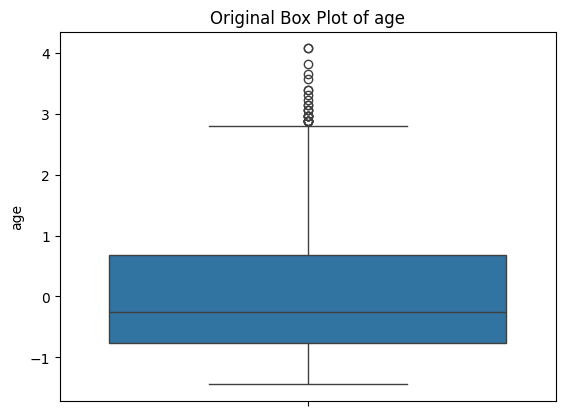

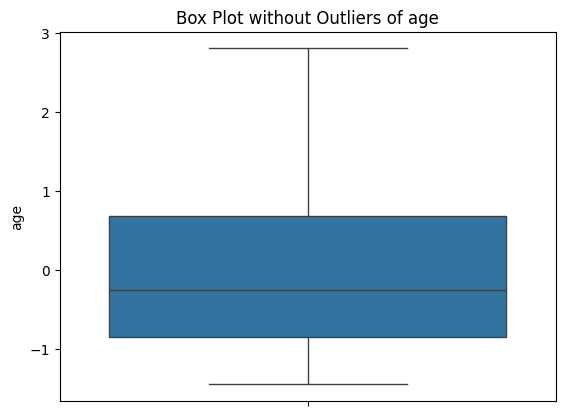

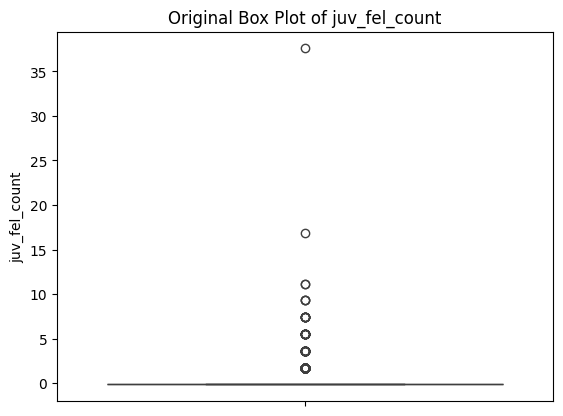

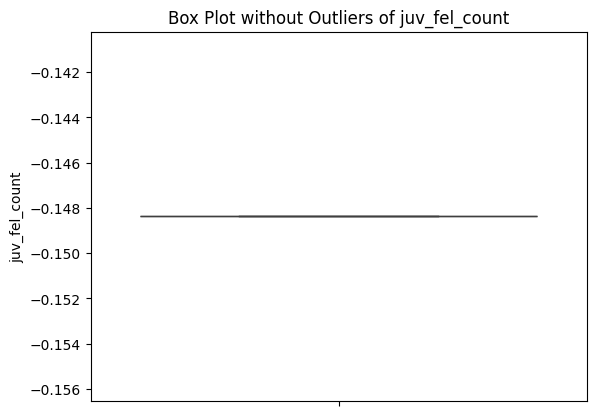

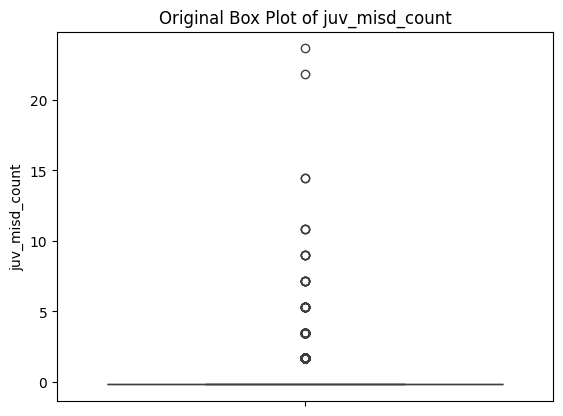

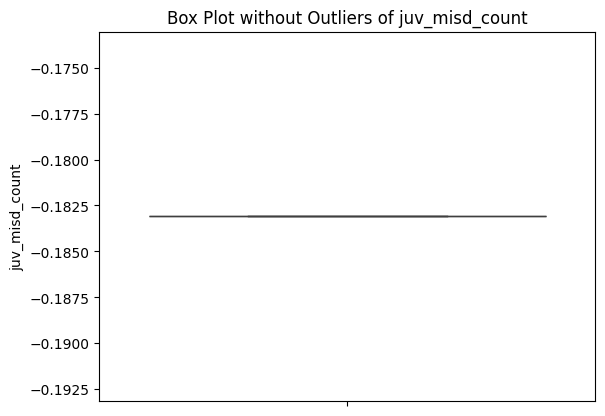

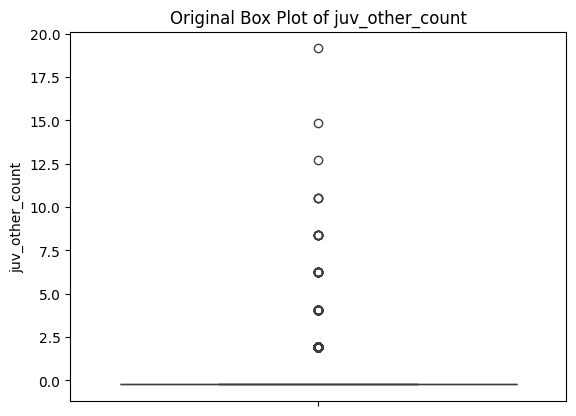

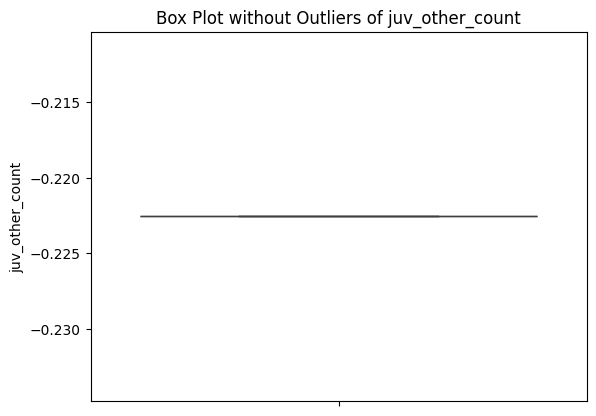

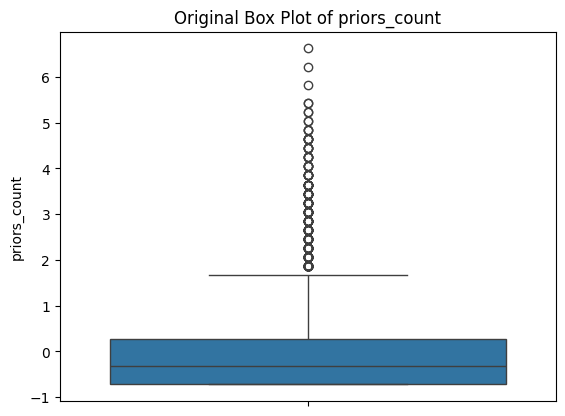

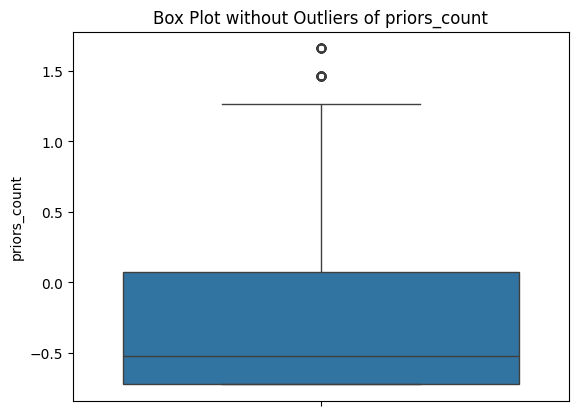

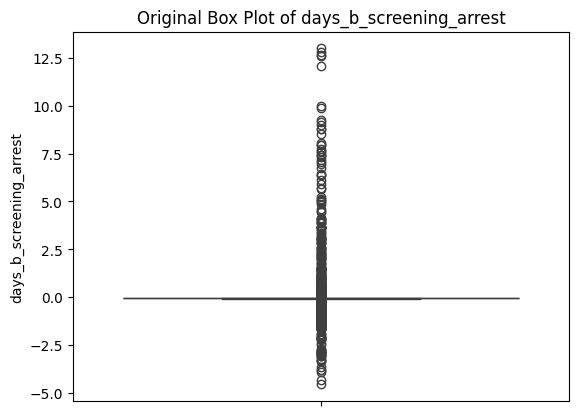

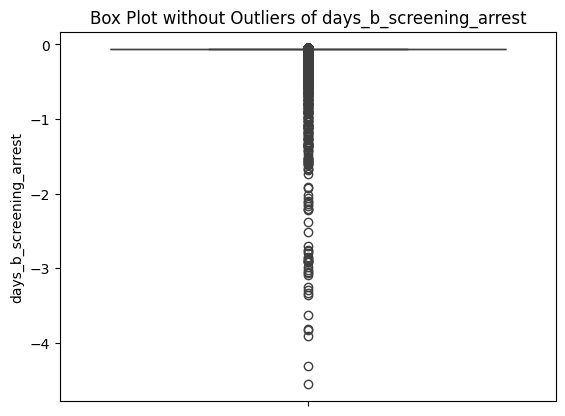

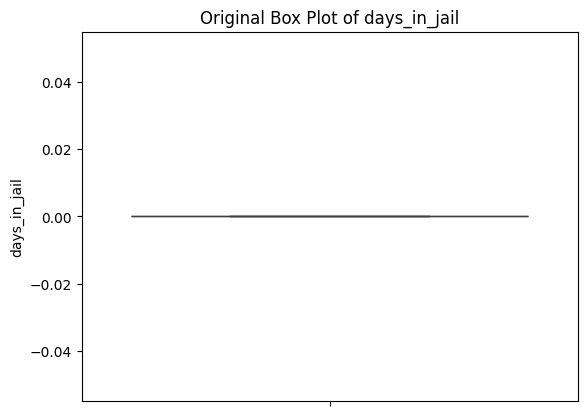

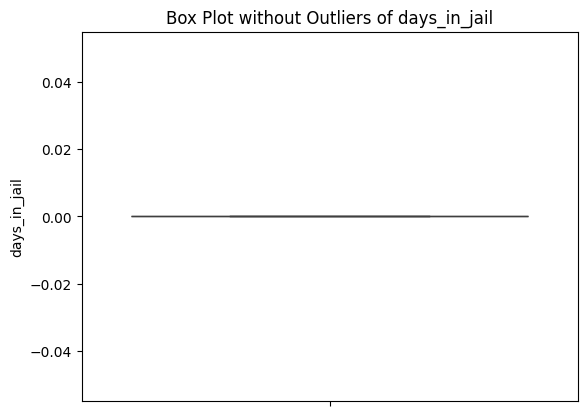

An error occurred while processing column 'age_cat': 'age_cat'
An error occurred while processing column 'score_text': 'score_text'
An error occurred while processing column 'decile_score': 'decile_score'
An error occurred while processing column 'sex_Female': 'sex_Female'
An error occurred while processing column 'sex_Male': 'sex_Male'
An error occurred while processing column 'race_African-American': 'race_African-American'
An error occurred while processing column 'race_Asian': 'race_Asian'
An error occurred while processing column 'race_Caucasian': 'race_Caucasian'
An error occurred while processing column 'race_Hispanic': 'race_Hispanic'
An error occurred while processing column 'race_Native American': 'race_Native American'
An error occurred while processing column 'race_Other': 'race_Other'
An error occurred while processing column 'c_charge_degree_F': 'c_charge_degree_F'
An error occurred while processing column 'c_charge_degree_M': 'c_charge_degree_M'
An error occurred while p

<Figure size 640x480 with 0 Axes>

In [44]:
for i, col in enumerate(df_imputed.columns):
    try:
        df_outlier_removal = outlier_removal(col)
        plt.savefig(f'figures/boxplot{col}.png')
    except Exception as e:
        print(f"An error occurred while processing column '{col}': {e}")

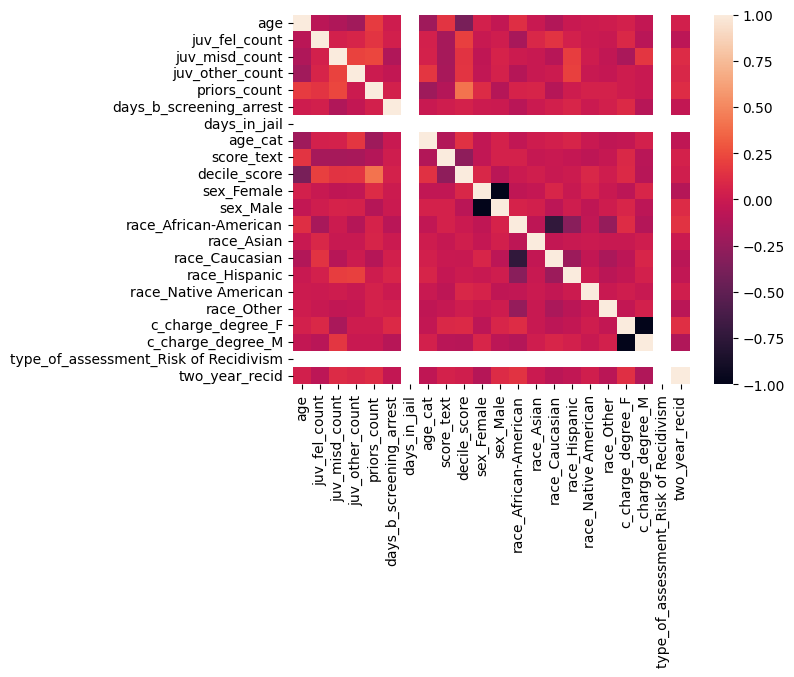

In [45]:
sns.heatmap(
    df_imputed.corr(),
)
plt.savefig(f'figures/heatmap.png')

In [46]:
correlation_matrix = df_imputed.corr()
correlation_pairs = (correlation_matrix.stack()
                     .loc[lambda x: (x > 0.8) | (x < -0.8)]
                     .reset_index()
                     .rename(columns={'level_0': 'Feature 1', 'level_1': 'Feature 2', 0: 'Correlation'}))

correlation_pairs = correlation_pairs[correlation_pairs['Feature 1'] != correlation_pairs['Feature 2']]

correlation_pairs['Sorted Features'] = correlation_pairs.apply(lambda row: tuple(sorted([row['Feature 1'], row['Feature 2']])), axis=1)

correlation_pairs = correlation_pairs.drop_duplicates(subset=['Sorted Features'])

correlation_pairs.drop(columns=['Sorted Features'], inplace=True)

print(correlation_pairs)

            Feature 1          Feature 2  Correlation
10         sex_Female           sex_Male         -1.0
20  c_charge_degree_F  c_charge_degree_M         -1.0


In [47]:
df_imputed.drop(columns=['sex_Female','c_charge_degree_F'], inplace=True)

In [48]:
df_imputed.to_csv("compas-scores-two-years-preprocessed.csv", index=False)

# RandomForest Features importance

In [49]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display
import seaborn as sns
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import train_test_split

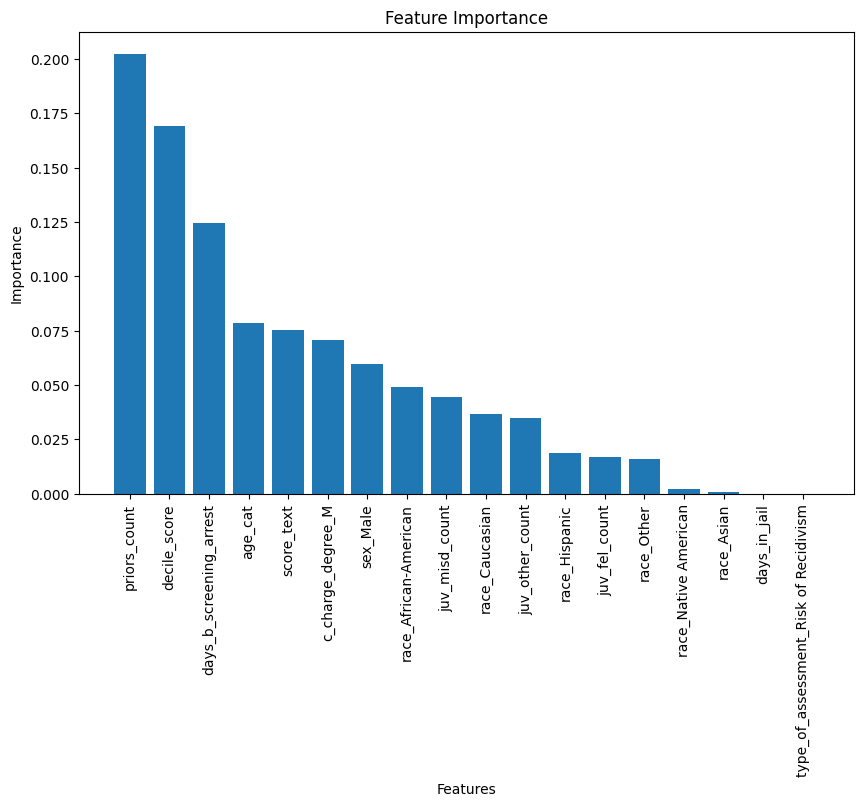

In [50]:
df = pd.read_csv("compas-scores-two-years-preprocessed.csv", index_col=0)

y = df['two_year_recid'].astype(int)

X = df.drop(columns=['two_year_recid'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

forest = RandomForestClassifier(n_estimators=100, random_state=0)

forest.fit(X_train, y_train)
forest.predict(X_test)

import matplotlib.pyplot as plt

importances = forest.feature_importances_
indices = (-importances).argsort()
sorted_features = [X.columns[i] for i in indices]
sorted_importances = importances[indices]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_features)), sorted_importances, align='center') 
plt.xticks(range(len(sorted_features)), sorted_features, rotation='vertical')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.title('Feature Importance')
plt.savefig(f'figures/importance_features_{col}.png')
plt.show()



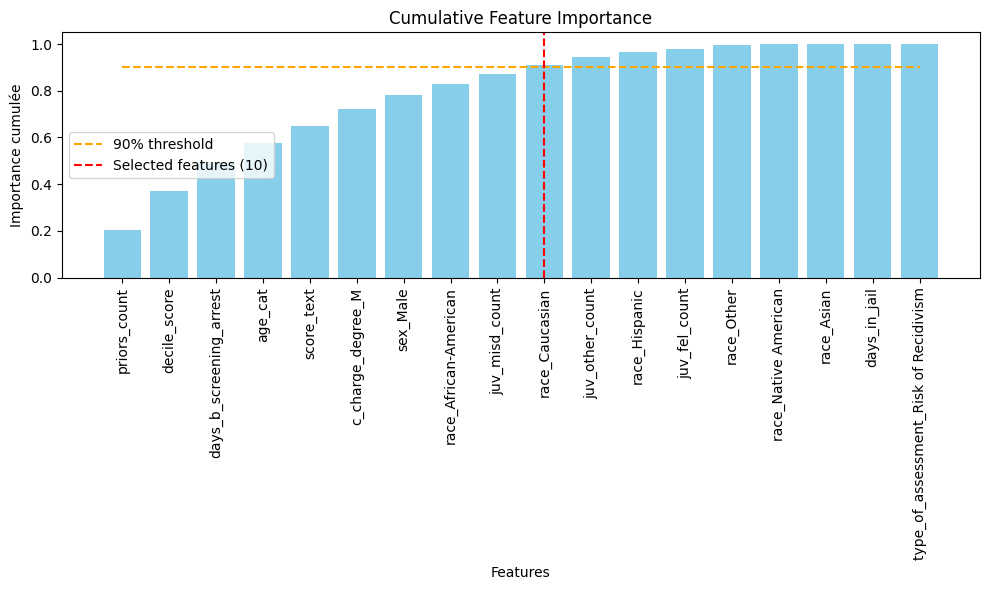

In [51]:
import numpy as np
threshold=0.9

cumulative_importances = np.cumsum(sorted_importances)

selected_index = np.where(cumulative_importances >= 0.9)[0][0]

plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_features)), cumulative_importances, align='center', color='skyblue')
plt.plot(range(len(sorted_features)), [0.9] * len(sorted_features), color='orange', linestyle='--', label='90% threshold')
plt.axvline(x=selected_index, color='red', linestyle='--', label=f'Selected features ({selected_index+1})')
plt.xticks(range(len(sorted_features)), sorted_features, rotation='vertical')
plt.ylabel('Importance cumulée')
plt.xlabel('Features')
plt.title('Cumulative Feature Importance')
plt.legend()
plt.tight_layout()
plt.savefig(f'figures/cumulative_importance_features_{col}.png')
plt.show()

In [52]:
def classes_equilibrees(labels):
    unique_classes, counts = np.unique(labels, return_counts=True)
    proportion_classes = counts / len(labels)
    equilibre = np.all(proportion_classes >= 0.1) and np.all(proportion_classes <= 0.9)
    return equilibre

classes_equilibrees(y)

np.True_